Resources Used
- wget.download('https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/_downloads/da4babe668a8afb093cc7776d7e630f3/generate_tfrecord.py')
- Setup https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/install.html

# 0. Setup Paths

In [1]:
WORKSPACE_PATH = 'Tensorflow/workspace'
SCRIPTS_PATH = 'Tensorflow/scripts'
APIMODEL_PATH = 'Tensorflow/models'
ANNOTATION_PATH = WORKSPACE_PATH + '/annotations'
IMAGE_PATH = WORKSPACE_PATH + '/images'
MODEL_PATH = WORKSPACE_PATH + '/models'
PRETRAINED_MODEL_PATH = WORKSPACE_PATH + '/pre-trained-models'
CONFIG_PATH = MODEL_PATH + '/my_ssd_mobnet/pipeline.config'
CHECKPOINT_PATH = MODEL_PATH + '/my_ssd_mobnet/'

In [2]:
import os
import object_detection
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

# 1. Create Label Map

In [2]:
labels = [{'name':'Helmet', 'id':1}, {'name':'NoHelmet', 'id':2}]

with open(ANNOTATION_PATH + '\label_map.pbtxt', 'w') as f:
    for label in labels:
        f.write('item{ \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 2. Create TF records

In [3]:
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x {IMAGE_PATH + '/train'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/train.record'}
!python {SCRIPTS_PATH + '/generate_tfrecord.py'} -x{IMAGE_PATH + '/test'} -l {ANNOTATION_PATH + '/label_map.pbtxt'} -o {ANNOTATION_PATH + '/test.record'}

Successfully created the TFRecord file: Tensorflow/workspace/annotations/train.record
Successfully created the TFRecord file: Tensorflow/workspace/annotations/test.record


# 3. Download TF Models Pretrained Models from Tensorflow Model Zoo

In [4]:
!cd Tensorflow && git clone https://github.com/tensorflow/models

Cloning into 'models'...
Updating files:  43% (1144/2659)
Updating files:  44% (1170/2659)
Updating files:  45% (1197/2659)
Updating files:  46% (1224/2659)
Updating files:  47% (1250/2659)
Updating files:  48% (1277/2659)
Updating files:  49% (1303/2659)
Updating files:  50% (1330/2659)
Updating files:  51% (1357/2659)
Updating files:  52% (1383/2659)
Updating files:  53% (1410/2659)
Updating files:  54% (1436/2659)
Updating files:  55% (1463/2659)
Updating files:  56% (1490/2659)
Updating files:  57% (1516/2659)
Updating files:  58% (1543/2659)
Updating files:  59% (1569/2659)
Updating files:  60% (1596/2659)
Updating files:  61% (1622/2659)
Updating files:  62% (1649/2659)
Updating files:  63% (1676/2659)
Updating files:  64% (1702/2659)
Updating files:  65% (1729/2659)
Updating files:  66% (1755/2659)
Updating files:  67% (1782/2659)
Updating files:  68% (1809/2659)
Updating files:  69% (1835/2659)
Updating files:  70% (1862/2659)
Updating files:  71% (1888/2659)
Updating files:  7

In [6]:
#wget.download('http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz')
#!mv ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz {PRETRAINED_MODEL_PATH}
#!cd {PRETRAINED_MODEL_PATH} && tar -zxvf ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz

# 4. Copy Model Config to Training Folder

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 

In [6]:
!mkdir {'Tensorflow\workspace\models\\'+CUSTOM_MODEL_NAME}
!cp {PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/pipeline.config'} {MODEL_PATH+'/'+CUSTOM_MODEL_NAME}

'cp' is not recognized as an internal or external command,
operable program or batch file.


# 5. Update Config For Transfer Learning

In [2]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [8]:
CONFIG_PATH = MODEL_PATH+'/'+CUSTOM_MODEL_NAME+'/pipeline.config'

In [9]:
config = config_util.get_configs_from_pipeline_file(CONFIG_PATH)

In [10]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [11]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(CONFIG_PATH, "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [12]:
pipeline_config.model.ssd.num_classes = 2
pipeline_config.train_config.batch_size = 10
pipeline_config.train_config.fine_tune_checkpoint = PRETRAINED_MODEL_PATH+'/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/checkpoint/ckpt-0'
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/train.record']
pipeline_config.eval_input_reader[0].label_map_path = ANNOTATION_PATH + '/label_map.pbtxt'
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [ANNOTATION_PATH + '/test.record']

In [13]:
# apply the custom config
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(CONFIG_PATH, "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [5]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --num_train_steps=7000""".format(APIMODEL_PATH, MODEL_PATH,CUSTOM_MODEL_NAME,MODEL_PATH,CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --num_train_steps=7000


# 7. Load Train Model From Checkpoint

In [3]:
import os
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

In [4]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(CONFIG_PATH)
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(CHECKPOINT_PATH, 'ckpt-11')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 8. Evaluate the model

In [16]:
print("""python {}/research/object_detection/model_main_tf2.py --model_dir={}/{} --pipeline_config_path={}/{}/pipeline.config --checkpoint_dir={}/{}""".format(APIMODEL_PATH, MODEL_PATH, CUSTOM_MODEL_NAME, MODEL_PATH, CUSTOM_MODEL_NAME, MODEL_PATH, CUSTOM_MODEL_NAME))

python Tensorflow/models/research/object_detection/model_main_tf2.py --model_dir=Tensorflow/workspace/models/my_ssd_mobnet --pipeline_config_path=Tensorflow/workspace/models/my_ssd_mobnet/pipeline.config --checkpoint_dir=Tensorflow/workspace/models/my_ssd_mobnet


### Jalankan via CMD command di atas

# 9. Detect from Images

In [15]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [16]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [17]:
paths = {
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images')
}

In [38]:
# IMAGE_PATH_TEST = IMAGE_PATH = WORKSPACE_PATH + '/images'
IMAGE_PATH1 = os.path.join(paths['IMAGE_PATH'], 'predict', 'for_test2.jpg')

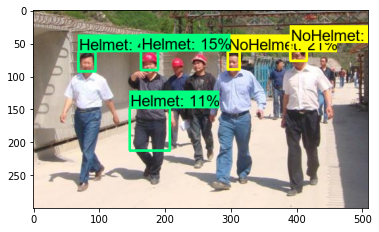

In [40]:
img = cv2.imread(IMAGE_PATH1)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.1,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [27]:
IMAGE_PATH2 = os.path.join(paths['IMAGE_PATH'], 'test', '003454_jpg.rf.a26e7e4e4aa891fd4cb80459de4fc408.jpg')

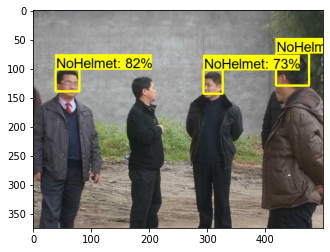

In [30]:
img = cv2.imread(IMAGE_PATH2)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
IMAGE_PATH3 = os.path.join(paths['IMAGE_PATH'], 'predict', 'for_test_helmet2.jpg')

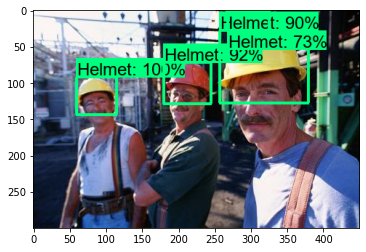

In [37]:
img = cv2.imread(IMAGE_PATH3)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=5,
            min_score_thresh=.5,
            agnostic_mode=False)

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Detect in Real-Time

In [5]:
import cv2 
import numpy as np

In [5]:
category_index = label_map_util.create_category_index_from_labelmap(ANNOTATION_PATH+'/label_map.pbtxt')

In [105]:
cap.release()

In [6]:
# Setup capture
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

In [7]:
while True: 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.2,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

### Unfortunately, it doesnt go well to live video that have much FPS. It will be better if it reduce to 1 or 2 FPS.

In [6]:
cap = cv2.VideoCapture("test_video.mp4")
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.2,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

ValueError: in user code:

    C:\Users\MISTER~1\AppData\Local\Temp/ipykernel_18392/1303302336.py:11 detect_fn  *
        image, shapes = detection_model.preprocess(image)
    C:\Users\mistersunday\AppData\Local\Programs\Python\Python39\lib\site-packages\object_detection\meta_architectures\ssd_meta_arch.py:484 preprocess  *
        normalized_inputs, self._image_resizer_fn)
    C:\Users\mistersunday\AppData\Local\Programs\Python\Python39\lib\site-packages\object_detection\utils\shape_utils.py:492 resize_images_and_return_shapes  *
        outputs = static_or_dynamic_map_fn(
    C:\Users\mistersunday\AppData\Local\Programs\Python\Python39\lib\site-packages\object_detection\utils\shape_utils.py:246 static_or_dynamic_map_fn  *
        outputs = [fn(arg) for arg in tf.unstack(elems)]
    C:\Users\mistersunday\AppData\Local\Programs\Python\Python39\lib\site-packages\object_detection\core\preprocessor.py:3327 resize_image  *
        new_image = tf.image.resize_images(
    C:\Users\mistersunday\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:206 wrapper  **
        return target(*args, **kwargs)
    C:\Users\mistersunday\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\image_ops_impl.py:1538 resize_images
        return _resize_images_common(
    C:\Users\mistersunday\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\ops\image_ops_impl.py:1396 _resize_images_common
        raise ValueError('\'images\' must have either 3 or 4 dimensions.')

    ValueError: 'images' must have either 3 or 4 dimensions.


In [42]:
detections = detect_fn(input_tensor)